# **TEAM ID**: *PTID-CDS-DEC-23-1722*

# **CLIENT**: *NewX Services*

# **CATEGORY**: *FORECASTING SPARE PARTS INVENTORY*

## Business Case

Inventory management is a critical aspect of any businees affecting profit, customer satisfaction and overall efficiency. Just in time (JIT) is an inventory management technique where inventory is stocked according to immediate customer demand rather than stockpilling behind. This requires highly accurate
forecasting of customer demand to manage invetory levels. 

In this project we look at 2 years worth of invoices to build a model predicting customer demand and inventory level. 

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import pmdarima as pm
from itertools import product

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [2]:
rd1=pd.read_csv('data.csv',sep=";")
rd1.head()
rd1.tail()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL
28481,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,AIR FILTER


## DOMAIN ANALYSIS

**1. invoice_date**--

- The date on which the invoice has been issued i.e., the date on which the spare part has been sold.

**2. job_card_date**--

- The date on which the spare parts arrived at the on-site inventory.

**3. business_partner_name**--

- Name of the business partner responible for selling and distribution of spare parts.

**4. vehicle_no**--

- Represents the vehicle to which spare part(s) has been sold.

**5. vehicle_model**--

- Identifies the model of the vehicle.

**6. current_km_reading**--

- Represents how much distance(in kms) has been covered by a vehicle.

**7. invoice_line_text**--

- Identifies what spare part has been sold to the specific vehicle in the row.

### Data Preprocessing

In [ ]:
# We are concerned with inventory managament. We need the inventory access date : job_card_date 
# and inventory item which we will calculate from invoice_line_text
# So drop superfluous columns -invoice_date,business_partner_name,vehicle_no,'vehicle_model',current_km_reading
rd=rd1[['job_card_date','invoice_line_text']]

#Change job_card_date into datetime format and set it as index
rd['date']=pd.to_datetime(rd['job_card_date'], format="%d-%m-%y")
rd.index=rd['date']
del rd['job_card_date'],rd['date']

### Basic Checks

In [3]:
rd.head()
rd.tail()
rd.describe()
rd.info()

,invoice_line_text
date,
2017-05-30,ENGINE OIL
2017-05-31,ENGINE OIL
2017-05-31,POLISH
2017-05-31,CONSUMABLES
2017-05-31,COOLANT OIL


,invoice_line_text
date,
2019-01-06,SPROCKET RUBBER
2019-01-06,CLUTCH CABLE
2019-01-06,OIL FILTER
2019-01-06,DISC OIL
2019-01-06,AIR FILTER


,invoice_line_text
count,28448
unique,502
top,ENGINE OIL
freq,3802


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28482 entries, 2017-05-30 to 2019-01-06
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   invoice_line_text  28448 non-null  object
dtypes: object(1)
memory usage: 445.0+ KB


In [5]:
rd.invoice_line_text.unique()

array(['ENGINE OIL', 'POLISH', 'CONSUMABLES', 'COOLANT OIL',
       'CHAIN LUBRICATION', '4 WAY SWITCH', '3M OIL', 'GENERAL SERVICE',
       'OIL FILTER', 'INDICATOR', 'HEAD REST', 'VALVE GUIDE',
       'TIMMING CHAIN', 'FOOT REST', 'LOW BEAM BULB', 'VALVE GRAINDING',
       'DISC PAD', 'LOADING GEAR', 'PACKING KIT', 'TIMMING CHAIN PAD',
       'TENSIONER', 'CLUTCH BELL REST', 'CLUTCH ASSEMBLY', 'VALVE KIT',
       'SPARK PLUG', 'ONE WAY CLUTCH', 'BORE KIT', 'AIR FILTER',
       'HEAD RUBBER', 'CLUTCH CABLE', 'CRANK SHAFT', 'BRAKE ADJUSTMENT',
       'BRAKE SHOE', 'AIR FILTER CHECKUP', 'DRUM BOLT WASHER',
       'TANK CLEANING', 'FORK BEND', 'GEAR SHAFT', 'CLUTCH COVER GASKET',
       'INDICATOR BULB', 'GEAR LEVER', 'HANDLEBAR', 'CRASH GUARD',
       'FORK OIL SEAL', 'FORK OIL', 'SIDE SHIELD', 'VISIOR',
       'FORK CONE SET', 'HEAD LIGHT DOOM', 'TANK ASSEMBLY',
       'Clutch cable', 'DISC LEVER', 'CARBURETOR CLEANING', 'SEAT COVER',
       'BUZZER', 'TAIL LAMP BULB', 'DISC OIL', 'DIS

There is 1 entry with 3 inventory items, a few with two but almost all of the 21K entries are 1 item.
We will therefore take every invoice as involving 1 spare part. We will also downsample our daily data to weekly
as that would be more relevant as far as inventory management is concerned. 

In [10]:
rd = rd[['invoice_line_text']].resample('W').count()
rd.rename(columns = {'invoice_line_text':'Spareparts'}, inplace = True) 
rd.head()
rd.tail()

,Spareparts
date,
2017-06-04,160
2017-06-11,340
2017-06-18,350
2017-06-25,310
2017-07-02,281


,Spareparts
date,
2018-12-09,576
2018-12-16,397
2018-12-23,548
2018-12-30,423
2019-01-06,431


## Exploratory Data Analysis

### Time Series Plot

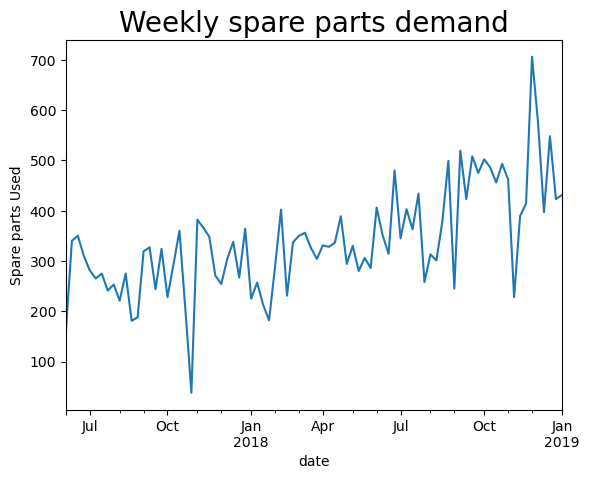

In [18]:
rd.plot(legend=None);
plt.ylabel('Spare parts Used');
plt.title('Weekly spare parts demand', fontsize=20);

### Histogram

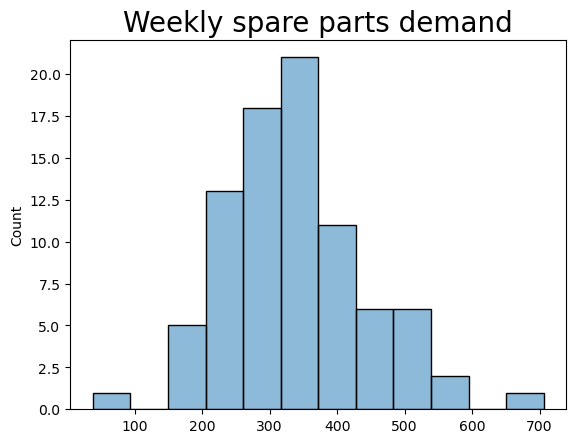

In [30]:
sns.histplot(rd,legend=None);
plt.title('Weekly spare parts demand', fontsize=20);


### Seasonal Decomposition

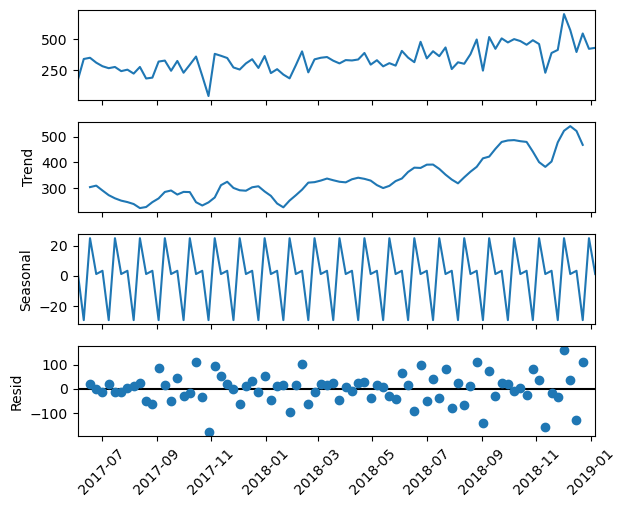

In [40]:
seasonal_decompose(rd,model='additive', period=4).plot();
plt.tick_params(axis='x', rotation=45);

#Seasonal decomposition plot showing trend, seasonality and residue

## Insights
 * We see a long time upward trend
 * We see a constant seasonal variation

### Autocorrelation function

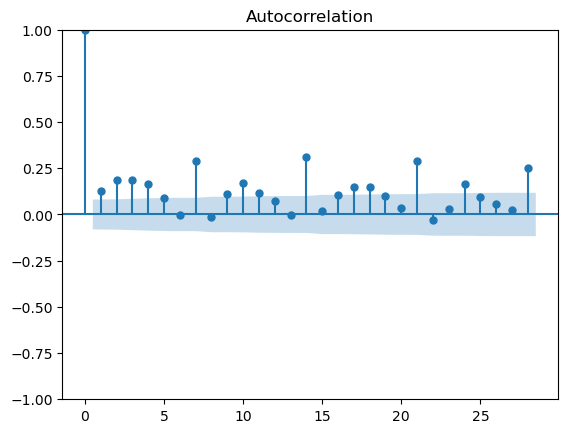

In [46]:

plot_acf(rd);

We have multiple significant spikes (Lags which are above the shaded area). We can see that there is a repeating pattern every 7 weeks. 

###  Partial autocorrelation function

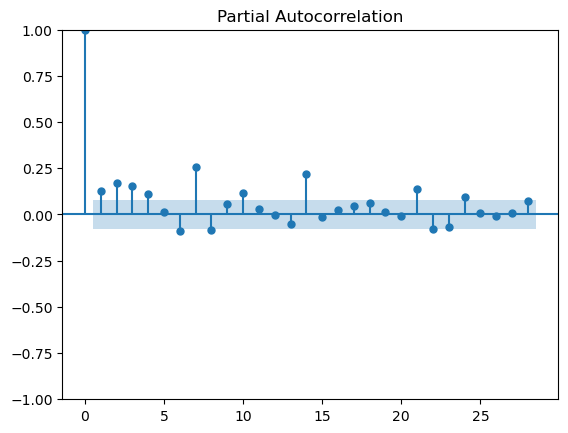

In [47]:
plot_pacf(rd);

### Stationarity

In [33]:
#Running the adfuller test to check for stationarity
adfuller(rd)[1]

0.587352489597432

p value 0.587 > 0.05, Therefore series is not stationary. 

In [34]:
#Let's look at it's first difference. 
adfuller(rd.diff(1).dropna())[1]

1.9348926572286206e-11

p value  < 0.05, Therefore data integrated to order 1 is stationary. 


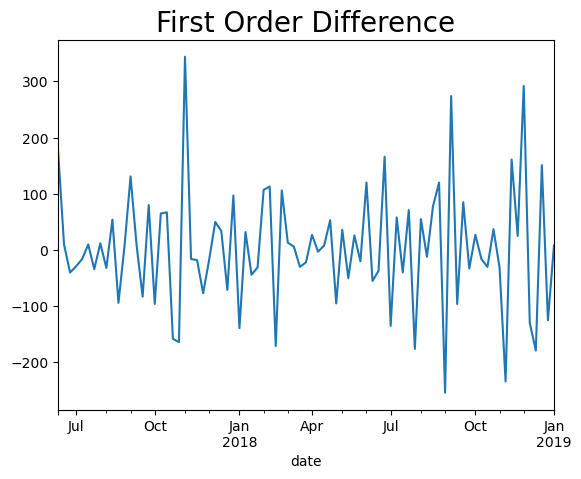

In [36]:
rd.diff(1).dropna().plot(legend=None);
plt.title('First Order Difference', fontsize=20);

### Frequency of Spare Parts

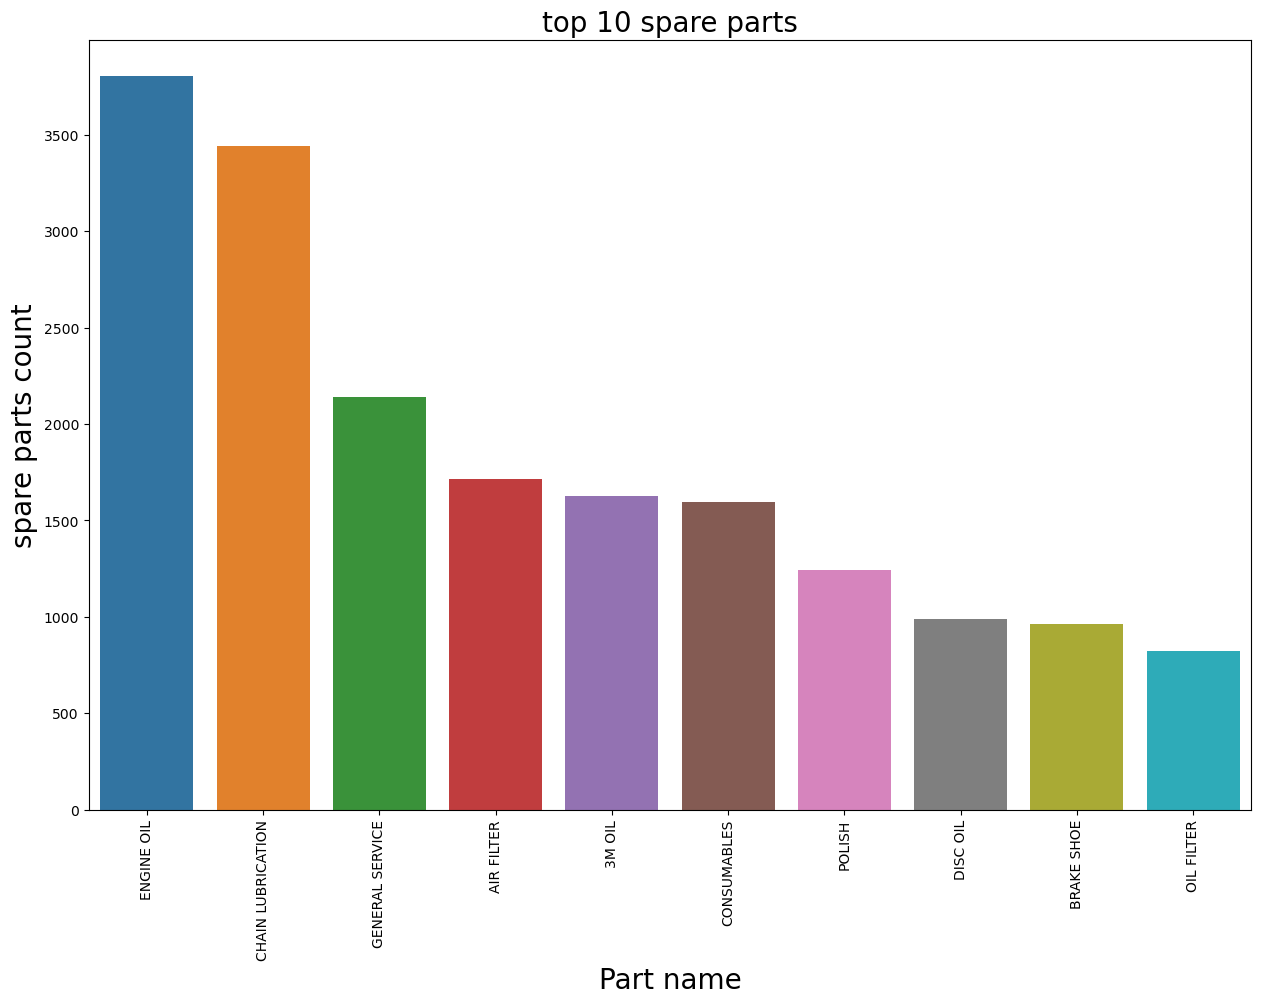

In [12]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Create the countplot
sns.countplot(data=rd1, x='invoice_line_text',
              order=rd1['invoice_line_text'].value_counts().index[:10],
              ax=ax);

# Set titles and labels 
ax.set_title('top 10 spare parts', fontsize=20)
ax.set_ylabel('spare parts count', fontsize=20);
ax.set_xlabel('Part name', fontsize=20);

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90);

# Show the plot
plt.show();

## Model Building

In [68]:
#Now that we have a stationary series, we can start forcasting
s=int(0.8*len(rd))
train,test=rd[:s],rd[s:-1]
#Partioning training and testing data, 80:20 train test split
train.shape
test.shape


(67, 1)

(16, 1)

We have clear trend and seasonality, so AR, MA and ARIMA models will not be good fits. We will 
jump straight into SARIMA model.

### SARIMA model

#### Parameter Tuning

In [69]:
#Sarima models have (p,d,q)(P, D, Q, s) where p is the order of autoregressive model, d is the degree of differencing,
#and q is the order of moving-average model.
#s is the seasonality and PDQ are the p,d,q of the seasonal order. 
#We use auto_arima to calculate the optimum value of (p,d,q)(P, D, Q, s)
pm.auto_arima(train, seasonal=True, m=12, test='adf',stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   67
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -383.957
Date:                            Tue, 27 Feb 2024   AIC                            777.914
Time:                                    17:01:30   BIC                            788.938
Sample:                                06-04-2017   HQIC                           782.276
                                     - 09-09-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.6326     84.924      0.443      0.658    -128.815     204.081
ar.L1          0.8780      0.276      3.186      0.001       0.338       1.418
ma.L1         -0.7715      0.384     -2.010      0.044      -1.524      -0.019
ma.S.L12       0.2405      0.159      1.510      0.131      -0.072       0.553
sigma2      5647.1706   1079.080      5.233      0.000    3532.212    7762.129
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.50   Prob(JB):                         0.30
Heteroskedasticity (H):               1.10   Skew:                            -0.17
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

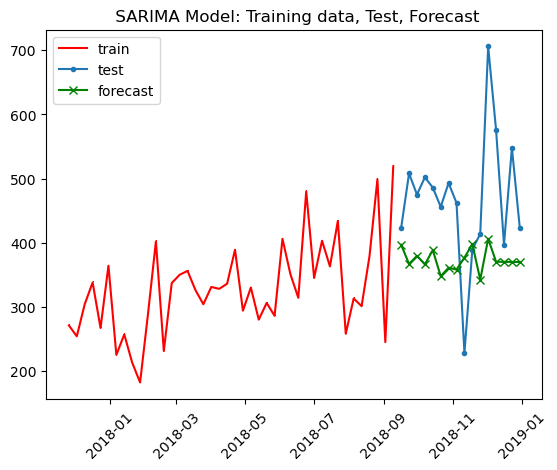

In [70]:
model = SARIMAX(train, order=(1, 0, 1),seasonal_order=(0,0,1,12));
pred=model.fit().forecast(steps=len(test));
plt.tick_params(axis='x', rotation=45);
plt.plot(train[int(0.3*len(rd)):],color='red',label='train',marker=',');
plt.plot(test,label='test',marker='.');
plt.plot(pred,color='green',label='forecast',marker='x');
plt.legend(['train','test', 'forecast'], loc ="best") ;
plt.title(" SARIMA Model: Training data, Test, Forecast");


In [71]:
#Metrics for the model
mse(test.values.flatten(),pred)
rmse(test.values.flatten(),pred)
rmspe(test.values.flatten(),pred)
mape(test,pred)

18279.597043279584

135.2020600556056

2.8542841258273284

0.24315006210248663

### Fb Prophet
Prophet library is an open source timeseries forcasting project originally developed at Facebook (aka Meta). 

In [72]:
fb=rd.copy()
fb.reset_index(inplace=True)
fb.columns=['ds','y']

s=int(0.8*len(rd))
fbtrain,fbtest=fb[:s],fb[s:-1]
fbtrain.shape
fbtest.shape

(67, 2)

(16, 2)

In [79]:
model = Prophet(yearly_seasonality=True,seasonality_mode='additive').fit(fbtrain) 
future=model.make_future_dataframe(periods=fbtest.shape[0], freq='W')
fbpred=model.predict(future)

17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] done processing


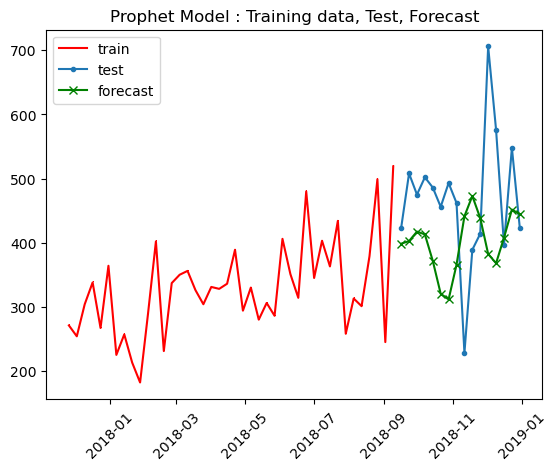

In [80]:
fbplot=pd.concat([fb.set_index('ds')['y'],fbpred.set_index('ds')['yhat']],axis=1)
train=fbplot.y[:s]
test=fbplot.y[s:-1]
pred=fbplot.yhat[s:-1]

plt.tick_params(axis='x', rotation=45);
plt.plot(train[int(0.3*len(rd)):],color='red',label='train',marker=',');
plt.plot(test,label='test',marker='.');
plt.plot(pred,color='green',label='forecast',marker='x');
plt.legend(['train','test', 'forecast'], loc ="best") ;
plt.title("Prophet Model : Training data, Test, Forecast");

In [75]:
#Metrics for the model
mse(test.values.flatten(),pred)
rmse(test.values.flatten(),pred)
rmspe(test.values.flatten(),pred)
mape(test,pred)

19227.164460909815

138.66205126461173

3.2741096608418006

0.24727829497429338

### Supervised ML models

In [26]:
def create_time_feature(df):
    df['dayofmonth'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.weekofyear
    return df

nd=rd.copy()
nd.reset_index(inplace=True)
nd=create_time_feature(nd)

x=nd.drop(columns=['Spareparts','date'])
y=nd.Spareparts
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [12]:
x_train.shape
y_test.shape

(58, 7)

(26,)

### XGBoost

In [46]:
#Hyper parametric tuning for Xgboost
n_estimators=[int(x) for x in np.linspace(start=50, stop=200, num=10)]
max_depth=[int(x) for x in np.linspace(2,20,num=11)]
min_samples_split=list(range(2,11))
min_samples_leaf=list(range(1,20))


par_grid={'n_estimators':n_estimators,
            'max_depth':max_depth,
            'min_samples_leaf':min_samples_leaf,
            'min_samples_split':min_samples_split,
            'learning_rate': [0.01, 0.05, 0.1, 0.5,1.0]
}

model=XGBRegressor();
grid=RandomizedSearchCV(model,par_grid,scoring='neg_mean_squared_error', n_iter=300,verbose=1,cv=3)
grid.fit(x,y);
parm=grid.best_params_;

Fitting 3 folds for each of 300 candidates, totalling 900 fits


In [41]:
#Calculate metrics for the optimal model
model=XGBRegressor(n_estimators=83,max_depth=2,min_samples_leaf=1,min_samples_split=7,learning_rate=0.05)
#model=XGBRegressor(**parm);
model.fit(x_train,y_train);#Training 

mse(y_test,model.predict(x_test))#Mean square Error
rmse(y_test,model.predict(x_test))#Root mean square Error
rmspe(y_test,model.predict(x_test))#Root mean square percentage Error
mape(y_test,model.predict(x_test))#Mean Absolute percentage Error

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, min_samples_leaf=1, min_samples_split=7,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=83, n_jobs=None, ...)

7532.505470965891

86.79000789817853

3.217491159629281

0.2312692609492316

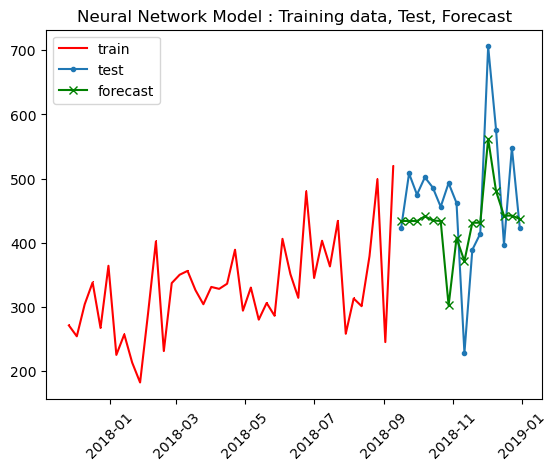

In [42]:
nd=rd.copy()
nd.reset_index(inplace=True)
nd=create_time_feature(nd)
nd['pred']=model.predict(nd.drop(columns=['Spareparts','date']))
nd.index=nd['date']

s=int(0.8*len(rd))
train=nd.Spareparts[:s]
test=nd.Spareparts[s:-1]
pred=nd.pred[s:-1]

plt.tick_params(axis='x', rotation=45);
plt.plot(train[int(0.3*len(rd)):],color='red',label='train',marker=',');
plt.plot(test,label='test',marker='.');
plt.plot(pred,color='green',label='forecast',marker='x');
plt.legend(['train','test', 'forecast'], loc ="best") ;
plt.title("Neural Network Model : Training data, Test, Forecast");
del nd;

### Neural Network
Multi-layer Perceptron

In [36]:
model=MLPRegressor()
par_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (150,100,50)],
          'activation': ['relu','tanh'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam','lbfgs','sgd']}
grid=GridSearchCV(model,par_grid,scoring='neg_mean_squared_error',verbose=1)
grid.fit(x,y)
parm=grid.best_params_
parm

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (150, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'lbfgs', 'sgd']},
             scoring='neg_mean_squared_error', verbose=1)

In [43]:
#metrics
model=MLPRegressor(**parm)
model.fit(x_train,y_train)#Training 

mse(y_test,model.predict(x_test))#Mean square Error
rmse(y_test,model.predict(x_test))#Root mean square Error
rmspe(y_test,model.predict(x_test))#Root mean square percentage Error
mape(y_test,model.predict(x_test))#Mean Absolute percentage Error

MLPRegressor(hidden_layer_sizes=(150, 100, 50), learning_rate='adaptive')

10235.82591347519

101.1722586160613

4.019139134333466

0.2841188779521295

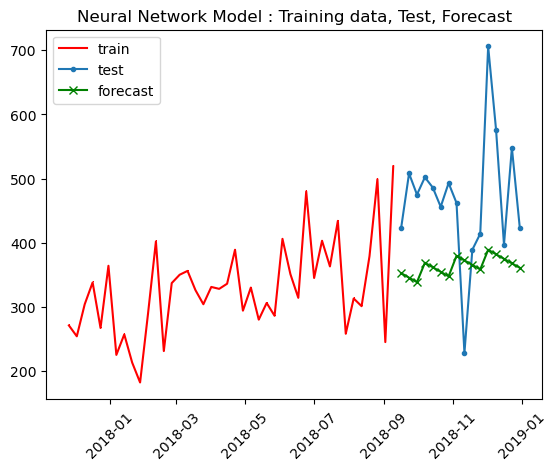

In [44]:
nd=rd.copy()
nd.reset_index(inplace=True)
nd=create_time_feature(nd)
nd['pred']=model.predict(nd.drop(columns=['Spareparts','date']))
nd.index=nd['date']

s=int(0.8*len(rd))
train=nd.Spareparts[:s]
test=nd.Spareparts[s:-1]
pred=nd.pred[s:-1]

plt.tick_params(axis='x', rotation=45);
plt.plot(train[int(0.3*len(rd)):],color='red',label='train',marker=',');
plt.plot(test,label='test',marker='.');
plt.plot(pred,color='green',label='forecast',marker='x');
plt.legend(['train','test', 'forecast'], loc ="best") ;
plt.title("Neural Network Model : Training data, Test, Forecast");
del nd;

### Gradient Boosting

In [44]:
#Hyper parametric tuning for Random Forest
n_estimators=[int(x) for x in np.linspace(start=50, stop=200, num=10)]
max_depth=[int(x) for x in np.linspace(1,15,num=11)]
min_samples_split=[2,4,10]
min_samples_leaf=list(range(1,15))


par_grid={'n_estimators':n_estimators,
            'max_depth':max_depth,
            'min_samples_leaf':min_samples_leaf,
            'min_samples_split':min_samples_split,
            'learning_rate': [0.01, 0.05, 0.1, 0.5,1.0]
}

model=GradientBoostingRegressor();
grid=RandomizedSearchCV(model,par_grid, n_iter=500,scoring='neg_mean_squared_error',verbose=1,cv=3)
grid.fit(x,y);
parm=grid.best_params_;

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [13]:
#Calculate metrics for the optimal model
model=GradientBoostingRegressor(learning_rate=0.5, max_depth=1, min_samples_split=10);
#model=GradientBoostingRegressor(**parm)
model.fit(x_train,y_train)#Training 

mse(y_test,model.predict(x_test))#Mean square Error
rmse(y_test,model.predict(x_test))#Root mean square Error
rmspe(y_test,model.predict(x_test))#Root mean square percentage Error
mape(y_test,model.predict(x_test))#Mean Absolute percentage Error

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, min_samples_split=10)

11880.17370883345

108.99620960764393

3.884696450741682

0.26838857744290345

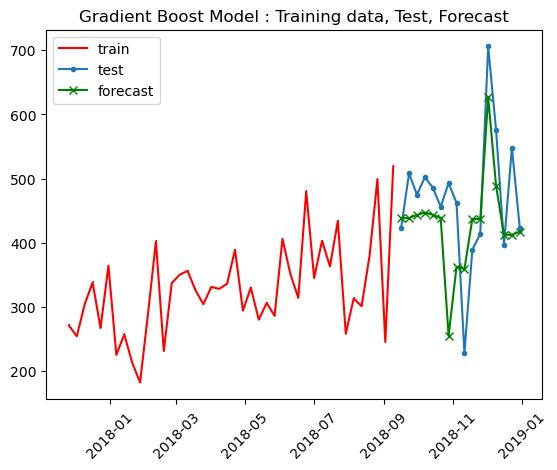

In [28]:
nd=rd.copy()
nd.reset_index(inplace=True)
nd=create_time_feature(nd)
nd['pred']=model.predict(nd.drop(columns=['Spareparts','date']))
nd.index=nd['date']

s=int(0.8*len(rd))
train=nd.Spareparts[:s]
test=nd.Spareparts[s:-1]
pred=nd.pred[s:-1]

plt.tick_params(axis='x', rotation=45);
plt.plot(train[int(0.3*len(rd)):],color='red',label='train',marker=',');
plt.plot(test,label='test',marker='.');
plt.plot(pred,color='green',label='forecast',marker='x');
plt.legend(['train','test', 'forecast'], loc ="best") ;
plt.title("Gradient Boosting Model : Training data, Test, Forecast");
del nd;

## Model Comparison

 **XGBoost** has the least Root mean square Error (RMSE) and lowest Mean absolute percentage error (MAPE) and should be used for deployment. 

| Model | RMSE |MAPE |
|:--------:|:--------:|:--------:|
| XGBoost |86.79 | 23.12%  | 
|  SARIMA  |135.20|  24.31%   |
| Gradient Boosting  |109.18|  27.25% |
|  FB Prophet  |138.66|  24.72%   | 
|  Neural Network  |101.17| 28.41%   | 


# Conclusion

We have created a ML model predicting the inventory level of spare parts. Using this, along with the percentage of spare parts in inventory figured out in the EDA, NewX Services can order spare parts to increase their efficiency. Additional data like price of spare part, size of spare part can be used along with the model to optimize performance in godown usage, cash reserves sunk in spare parts, etc. 